# House Price Prediction - Written by Patrick Da Silva
### Note on PQDlibrary
 - I created a separate library called PQDlibrary that contains functions I wrote to help preprocess the data.
 - This was meant to make the project more modular and abstract away unnecessary details
 
### Project Outline
##### 1. Import Dependencies and Load Data
##### 2. Preprocess Data  
##### 3. Explore and Create Strong Features
##### 4. Train and Evaluate Model
##### 5. Results and Discussion

## 1 Import Dependencies and Load Data

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
# My custom library
from PQDlibrary.PQDlib import PQDfuncs

sns.color_palette('colorblind')
sns.set_style('whitegrid')

In [2]:
# Read in training and testing data
house_data_train_raw = pd.read_csv('data/train.csv', index_col='Id')
house_data_test_raw  = pd.read_csv('data/test.csv', index_col='Id')
# Concatenate train and test sets for easier preprocessing
house_data_raw = pd.concat([house_data_train_raw, house_data_test_raw])

## 2 Preprocess Data

### 2.1 Clean Data
This dataset has some known issues:
 - Incosistent data entry
 - Corrupt data 
 - Incorrect category encoding <br>

I will fix those before moving on.

In [3]:
# The data description for Exterior2nd has a category "BrkComm," but in the dataset it is "Brk Cmn" - fix this
house_data_raw.Exterior2nd.replace({'Brk Cmn': 'BrkComm'}, inplace=True)
# GarageYrBlt dates are corrupt, fill in these dates with the year the house was built
house_data_raw.GarageYrBlt.where(house_data_raw.GarageYrBlt <= 2010, house_data_raw.YearBuilt, inplace=True)
# Category names should not start with a number
house_data_raw.rename (columns={ 
    '1stFlrSF': 'FirstFlrSF',
    '2ndFlrSF': 'SecondFlrSF',
    '3SsnPorch': 'ThreeSsnPorch'
    }, inplace=True)

In [4]:
# Encode categorical features with the correct types (see myfuncs for exact transformations)
house_data_encoded = PQDfuncs.categorical_feature_encoding(house_data_raw)

### 2.2 Impute Missing Data

In [5]:
numerical_features   = [colname for colname in house_data_encoded \
                        if house_data_encoded[colname].dtype in ['int64','float64']]
categorical_features = [colname for colname in house_data_encoded \
                        if house_data_encoded[colname].dtype in ['category']]

house_data_imputed = house_data_encoded.copy()

house_data_imputed[numerical_features]   = house_data_imputed[numerical_features].fillna(0)
house_data_imputed[categorical_features] = house_data_imputed[categorical_features].fillna("None")

In [6]:
# Quick check that none of the data is missing
missing_by_col = house_data_imputed.isnull().sum()
print("Values Missing by Column")
print(missing_by_col[missing_by_col > 0].sort_values())

Values Missing by Column
Series([], dtype: int64)


In [7]:
# Split data back into training and testing sets
house_data_train = house_data_imputed.loc[house_data_train_raw.index, :].copy()
house_data_test  = house_data_imputed.loc[house_data_test_raw.index, :].copy()

## 3. Explore and Create Strong Features

### 3.1 Compute Mutual Information

In [8]:
house_data_MI = house_data_train.copy()
target_MI     = house_data_MI.pop("SalePrice")
# Call function to calculate mutual information scores (see PQDlibrary for details of how I implemented this)
mi_scores     = PQDfuncs.mi_scoring(house_data_MI, target_MI)

#### Drop features with 0 mutual information

In [9]:
# Features with low mutual information could help to inform features with higher mutual information ->
# check 3.2 Discovering Relationships for more info
# However many of these features will just add noise, so I will remove them
mi_dict = {feature: score for feature, score in mi_scores.items() if score > 0}
mi_features = list(mi_dict.keys())
mi_features.append('SalePrice')
house_data_train = house_data_train.loc[:, mi_features]
house_data_test  = house_data_test.loc[:, mi_features]

### 3.2 Discovering Relationships

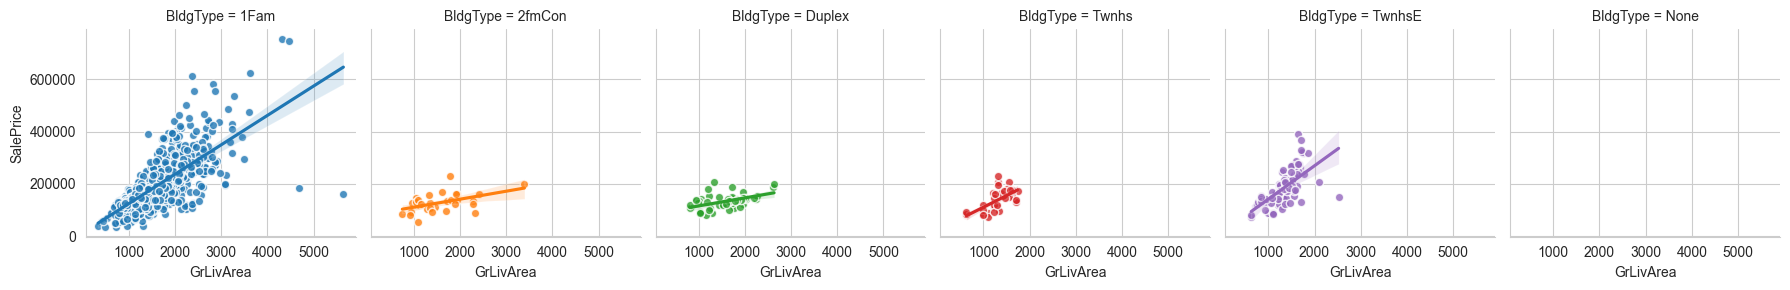

In [10]:
sns.lmplot(
    x='GrLivArea', y='SalePrice', hue='BldgType', col='BldgType',
    data=house_data_train, scatter_kws={"edgecolor": 'white'}, col_wrap=6, height=3,
);

This plot demonstrates the relationship between "Building Type" and "Above-ground Living Area."<br>
Building Type had a low mutual information score on its own, but this plot indicates that building type may actually be an informative feature when combined with above ground living area. <br>
I will compute a mathematical transformation between these two variables (see interactionTransformer in PQDlibrary).

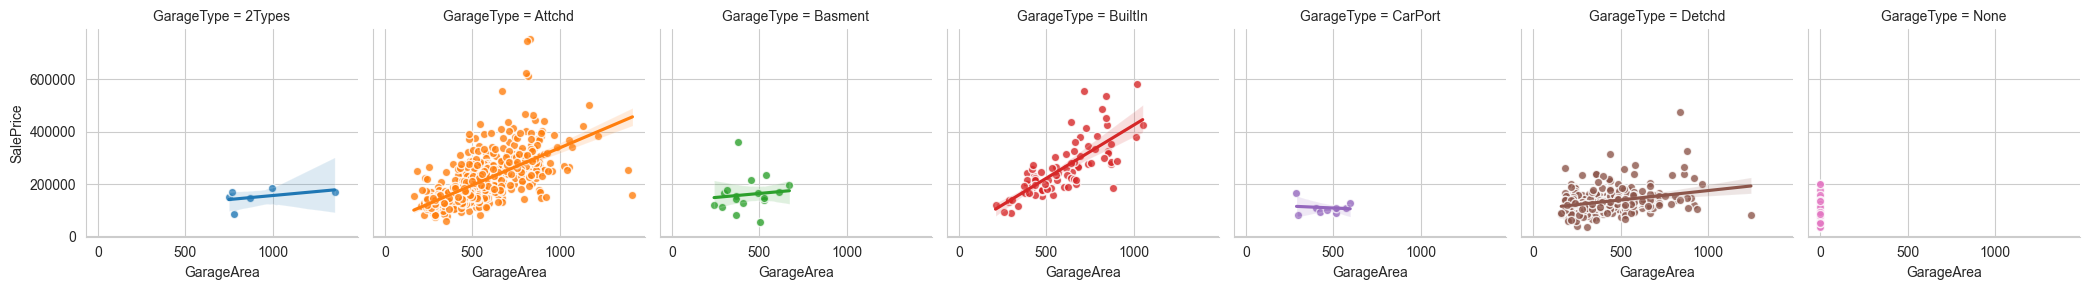

In [11]:
sns.lmplot(
    x='GarageArea', y='SalePrice', hue='GarageType', col='GarageType',
    data=house_data_train, scatter_kws={"edgecolor": 'white'}, col_wrap=7, height=3,
);

This plot demonstrates the relationship between "Garage Area" and "Garage Type." <br>
Because the trendline varies across garage type, it is expected that creating a new feature between these variables will add more information the model. <br>
I will compute a mathematical transformation between these two variables (see interactionTransformer in PQDlibrary).

### 3.3 Transformations

#### Define Transformations

In [12]:
def allFeatureTransformations(house_data_train, house_data_test):
    """ Combines all feature engineering into one function """
    # I realize that I am copying the entire DataFrame for each transformation
    # In my next project I will prioritize memory management -> 
    # potentially by creating single column features joining the features the the DataFrame at the end
    
    house_data_train_fe = house_data_train.copy()
    train_target = house_data_train_fe.pop('SalePrice')
    house_data_test_fe  = house_data_test.copy()
    house_data_test_fe.drop('SalePrice', axis=1, inplace=True)
    house_data_fe = pd.concat([house_data_train_fe, house_data_test_fe]) 
    
    # Apply label encoding to cateogrical features
    house_data_fe = PQDfuncs.labelEncoder(house_data_fe)

    # Apply mathematical transformations to DataFrame
    house_data_fe = PQDfuncs.mathTransformations(house_data_fe)

    # Apply interaction transformations to DataFrame
    house_data_fe = PQDfuncs.interactionTransformer(house_data_fe)
    
    # Apply count transformation to DataFrame
    house_data_fe = PQDfuncs.countTransformer(house_data_fe)
    
    # Apply grouping transformation to DataFrame
    house_data_fe = PQDfuncs.groupTransformer(house_data_fe)
    
    
    # K-means Clustering
    # Discover 'hidden' groups in the data by using this unsupervised learning algorithm
    
    # Cluster 1
    # choosing to cluster with features related to area
    clustering_features1 = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']
    cluster_name1 = 'AreaCluster'
    house_data_fe = PQDfuncs.kMeansCluster(house_data_fe, clustering_features1, 11, cluster_name1)
    # Cluster 2
    # choosing to cluster a single feature: Year Built
    clustering_features2 = ['YearBuilt']
    cluster_name2 = 'YearBuiltCluster'
    house_data_fe = PQDfuncs.kMeansCluster(house_data_fe, clustering_features2, 5, cluster_name2)
    
    house_data_train_fe = house_data_fe.loc[house_data_train_fe.index, :].copy()
    house_data_test_fe  = house_data_fe.loc[house_data_test_fe.index, :].copy()
    house_data_train_fe['SalePrice'] = train_target
    
    return house_data_train_fe, house_data_test_fe

#### Apply Transformations to Training and Testing Data

In [13]:
house_data_train_fe, house_data_test_fe = allFeatureTransformations(house_data_train, house_data_test)

#### Plotting Results For Clusters

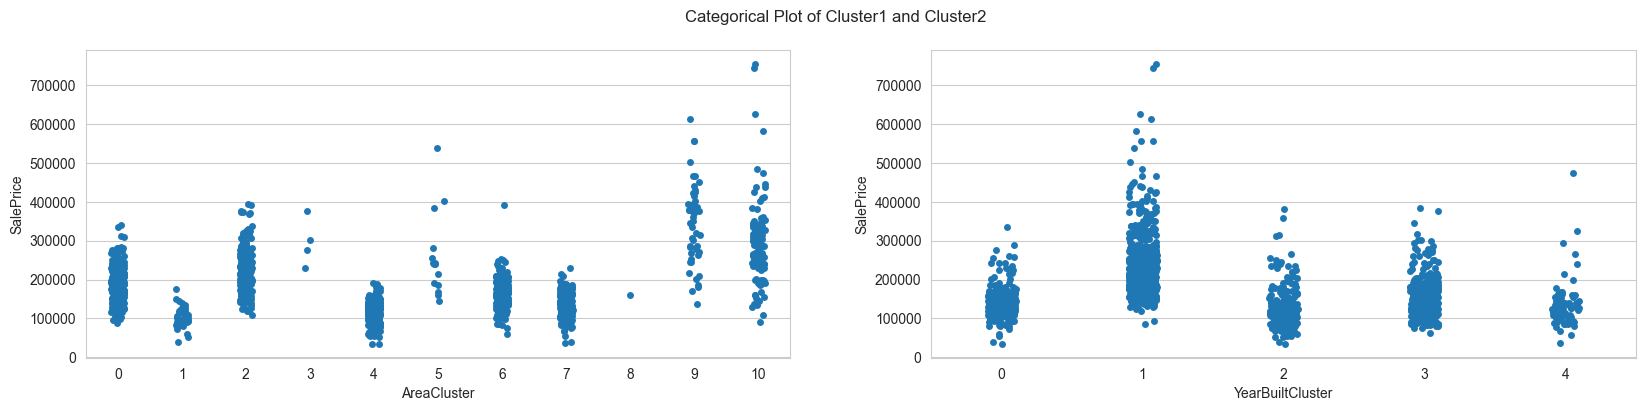

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
fig.suptitle('Categorical Plot of Cluster1 and Cluster2')
sns.stripplot(x=house_data_train_fe['AreaCluster'], y=house_data_train_fe['SalePrice'], ax=ax1);
sns.stripplot(x=house_data_train_fe['YearBuiltCluster'], y=house_data_train_fe['SalePrice'], ax=ax2);

##### I tried many different clustering values and these gave the best Root Mean Squared Log Error (RMSLE)

## 4 Train and Evaluate Model

Mean Absolute Error: 14938.08493150685
RMSLE: 0.11422429785454508


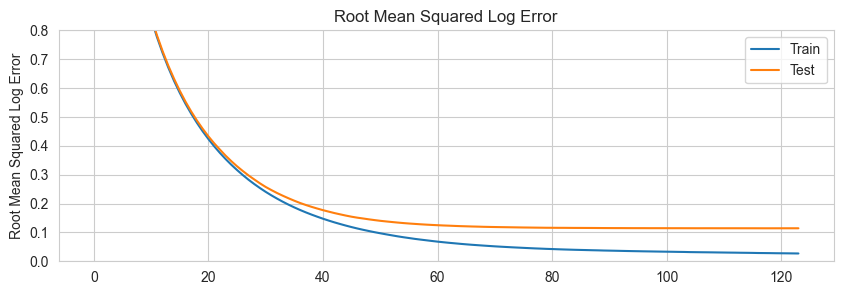

In [15]:
X = house_data_train_fe.copy()
y = X.pop('SalePrice')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

# I ran this for several iterations to find the best paramaters
# Next time I may look into some optimization methods, such as Optuna, GridSearchCV, BayesSearchCV, etc.
model = XGBRegressor(
    max_depth=9,           
    learning_rate=0.05,   
    n_estimators=1000,     
    min_child_weight=1,  
    colsample_bytree=0.2, 
    subsample=0.9,    
    reg_alpha=10.0, 
    reg_lambda=1.0,
    num_parallel_tree=2,
    early_stopping_rounds=5,
    random_state=0,
    eval_metric=['rmsle', 'rmsle'],
)
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Modified From https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

# make predictions for test data
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]

# evaluate predictions
mae = mean_absolute_error(y_valid, predictions)
rmsle = mean_squared_error(np.log(y_valid), np.log(predictions))
rmsle = np.sqrt(rmsle)
print("Mean Absolute Error:", mae)
print("RMSLE:", rmsle)

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# plot RMSLE to look for evidence of overfitting
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylim(0,0.8)
plt.ylabel('Root Mean Squared Log Error')
plt.title('Root Mean Squared Log Error')
plt.show()

##### There appears to be no evidence of overfitting

## 5 Results and Discussion

In [16]:
# Scoring test data for submission to Kaggle Competition: House Prices - Advanced Regression Techniques
test_predictions = model.predict(house_data_test_fe)
output = pd.DataFrame({'Id': house_data_test_fe.index,
                       'SalePrice': test_predictions})
output.to_csv('data/submission.csv', index=False)

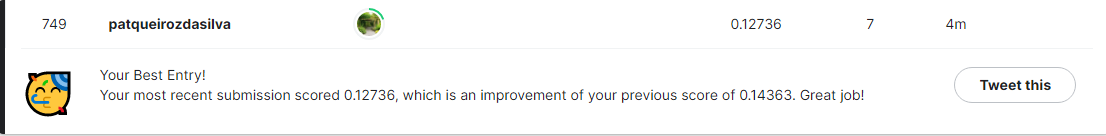
On completely novel data, the model I trained had a root mean squared log error of 0.127. <br>
Additionally, on the validation data, the model predicted on average about $15,000 from the mean. There is definitely room for improvement!

## Improvements
1. Gain more domain knowledge of real estate to better construct predictor features.
2. Utilize memory management techniques to capitalize on more efficient resource consumption for larger datasets.
3. Implement cross-validation to get a more robust measure of model quality.
